# import some library

In [153]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#  sklearn.cross_validation for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import random
from sklearn import svm
from sklearn import grid_search
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable


# define some parameters

In [154]:
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient =  9 # HOG orientations
pix_per_cell = 5 # HOG pixels per cell
cell_per_block = 3 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [450, None] # Min and max in y to search in slide_window()

debug = False

# read images

In [155]:
# Read in cars and notcars
vehicle_images_location = glob.glob('./data/vehicles/*/*.png')
non_vehicle_images_location = glob.glob('./data/non-vehicles/*/*.png')

# # Reduce the sample size because
# # The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# vehicle_images_location = vehicle_images_location[0:sample_size]
# non_vehicle_images_location = non_vehicle_images_location[0:sample_size]

print(len(vehicle_images_location), len(non_vehicle_images_location))

8792 8968


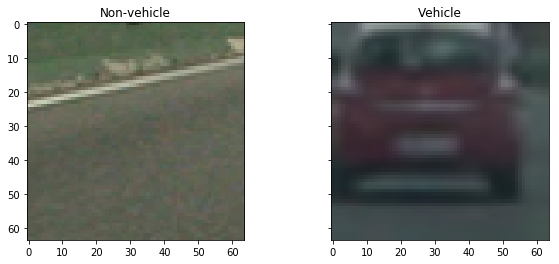

In [156]:
no_car_image = mpimg.imread(non_vehicle_images_location[1000])
car_image = mpimg.imread(vehicle_images_location[1000])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

ax0.axis('on')
ax0.imshow(no_car_image,cmap=plt.cm.gray)
ax0.set_title('Non-vehicle',fontsize=12)
ax1.axis('on')
ax1.imshow(car_image, cmap=plt.cm.gray)
ax1.set_title('Vehicle',fontsize=12)
plt.savefig("./report_images/1-origin-images.png")
plt.show()

# get HOG features

/Users/zhonghaixing/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


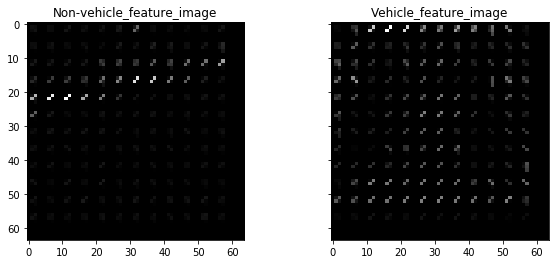

In [172]:
if debug == True:
    orient =  12 # HOG orientations
    pix_per_cell = 6 # HOG pixels per cell
    cell_per_block = 3 # HOG cells per block

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
#                                   block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
#                        block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
no_car_image_cov = cv2.cvtColor(no_car_image , cv2.COLOR_RGB2GRAY)
car_image_cov = cv2.cvtColor(car_image , cv2.COLOR_RGB2GRAY)
    
no_car_image_feature, no_car_image_feature_image = get_hog_features(no_car_image_cov,
                                                                    orient = orient,
                                                                    pix_per_cell = pix_per_cell, 
                                                                    cell_per_block = cell_per_block,
                                                                    vis = True, 
                                                                    feature_vec=True)
car_image_feature, car_image_feature_image = get_hog_features(car_image_cov,
                                                                    orient = orient,
                                                                    pix_per_cell = pix_per_cell, 
                                                                    cell_per_block = cell_per_block,
                                                                    vis = True, 
                                                                    feature_vec=True)

fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

ax2.axis('on')
ax2.imshow(no_car_image_feature_image,cmap=plt.cm.gray)
ax2.set_title('Non-vehicle_feature_image',fontsize=12)
ax3.axis('on')
ax3.imshow(car_image_feature_image, cmap=plt.cm.gray)
ax3.set_title('Vehicle_feature_image',fontsize=12)
plt.savefig("./report_images/2-images-feature.png")
plt.show()

# get bin features

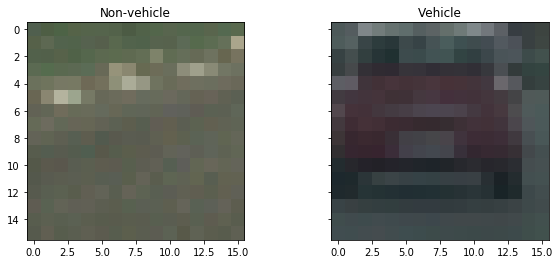

In [158]:
if debug == True:
    spatial_size = (16, 16) # Spatial binning dimensions

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()/256
    features = features/features.max()
    # Return the feature vector
    return features

fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

ax4.axis('on')
ax4.imshow(cv2.resize(no_car_image, spatial_size),cmap=plt.cm.gray)
ax4.set_title('Non-vehicle',fontsize=12)
ax5.axis('on')
ax5.imshow(cv2.resize(car_image, spatial_size), cmap=plt.cm.gray)
ax5.set_title('Vehicle',fontsize=12)
plt.savefig("./report_images/3-images-resize.png")
plt.show()

# get color features

In [159]:
if debug == True:
    color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    hist_bins = 32    # Number of histogram bins
    
# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    hist_features = hist_features/hist_features.max()
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



# extract one image features(include color features and HOG features)

In [160]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# get images features

In [161]:
car_features = extract_features(vehicle_images_location, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicle_images_location, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

/Users/zhonghaixing/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
/Users/zhonghaixing/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:17: RuntimeWarning: invalid value encountered in minimum
  out = np.minimum(out, 0.2)


# start to train SVM 

In [ ]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features))

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scalar to the both of training data and test data
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Use a linear SVC
t = time.time()
parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
# svc = LinearSVC()
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)
# Check the training time for the SVC
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')

# Apply the best C for the training.
svc = LinearSVC(C=clf.best_params_['C'])
svc.fit(X_train, y_train)
score_model = round(svc.score(X_test, y_test),4)
print('Test Accuracy is {} '.format(score_model))

In [132]:
color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient =  9 # HOG orientations
pix_per_cell = 5 # HOG pixels per cell
cell_per_block = 3 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [450, None] # Min and max in y to search in slide_window()

def data_list_creator():
    '''
    Function to create the training and test dataset, which are including file paths for images of cars and non-cars.
    :return: list of the file paths for images of cars and non-cars
    '''
    # Read in cars and notcars
    images_car_far = glob.glob('./data/vehicles/GTI_Far/*.png')
    images_car_left = glob.glob('./data/vehicles/GTI_Left/*.png')
    images_car_MiddleClose = glob.glob('./data/vehicles/GTI_MiddleClose/*.png')
    images_car_right = glob.glob('./data/vehicles/GTI_Right/*.png')
    images_car_KITTI_extracted = glob.glob('./data/vehicles/KITTI_extracted/*.png')
    images_noncar_Extras = glob.glob('./data/non-vehicles/Extras/*.png')
    images_noncar_GIT = glob.glob('./data/non-vehicles/GTI/*.png')
    cars = images_car_far + images_car_left + images_car_MiddleClose + images_car_right + images_car_KITTI_extracted
    notcars = images_noncar_Extras + images_noncar_GIT
    print('Number of cars:{}, Number of non-cars: {}'.format(len(cars),len(notcars)))

    # Shuffle original data
    random.shuffle(cars)  # length is 8792
    random.shuffle(notcars)  # length is 8968

    return cars,notcars

# Read the training/test data
cars, notcars = data_list_creator()

# Create an array stack of feature vectors
X = np.hstack((cars, notcars))

# Define the labels vector
y = np.hstack((np.ones(len(cars)), np.zeros(len(notcars))))

# Split data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# # Reduce the sample size
# if sample_size == None:
#     pass
# else:
#     X_train = X_train[0:sample_size]
#     y_train = y_train[0:sample_size]

# Define the parameter to compute the features
orient = 9  # HOG orientations
pix_per_cell = 5  # HOG pixels per cell
cell_per_block = 3  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins

# Compute the features of the training set
X_train = extract_features(
    X_train, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
)

# Compute the features of the test set
X_test = extract_features(
    X_test, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
    orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
    spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat
)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scalar to the both of training data and test data
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Use a linear SVC
t = time.time()
parameters = {'kernel': ('linear', 'rbf'), 'C': [1, 10]}
# svc = LinearSVC()
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)
# Check the training time for the SVC
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')

# Apply the best C for the training.
svc = LinearSVC(C=clf.best_params_['C'])
svc.fit(X_train, y_train)
score_model = round(svc.score(X_test, y_test),4)
print('Test Accuracy is {} '.format(score_model))

Number of cars:8792, Number of non-cars: 8968
3687.62 Seconds to train SVC...
Test Accuracy is 0.9336 


In [134]:
# Dump the model data and the related parameters
output_sum = {
    'model':svc,'color_space':color_space,'scaler':X_scaler,'orient':orient,'pix_per_cell':pix_per_cell,
    'cell_per_block':cell_per_block,'spatial_size':spatial_size,'hist_bins':hist_bins,
    'spatial_feat': spatial_feat, 'hist_feat': hist_feat, 'hog_feat': hog_feat,
}
with open("model2", 'wb') as handle:
        pickle.dump(output_sum, handle, protocol=pickle.HIGHEST_PROTOCOL)

# use trained SVM to find cars

In [124]:
def conv_color_space(img, color_space):
    '''
    Function to convert the color space of the image from BGR to the specific color space.
    :param img: BGR image
    :param color_space: the target color space
    :return: img data with the specified color space of color_space.
    '''
    if color_space != 'BGR':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif color_space == 'RGB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    return(feature_image)

color_space: HLS


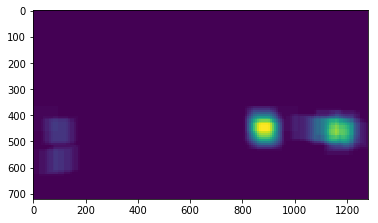

In [267]:
def find_cars(img, xstart,xstop, ystart, ystop, scale, svm_model_path):
    '''
    Compute heat map indicating the image space including the car.
    Heatmap will be computed with sliding windows method.
    <Sliding window method>
    ==> Divide the image into small windows. (There are the overlaps of each window.)
    ==> Judge whether the image includes car or not.
    ==> Sum up how many times each pixel was judged as "car". This count will be returned as the heatmap
    :param img: target image
    :param xstart: start point of the X coordinate in the img to compute heat map
    :param xstop: end point of the X coordinate in the img to compute heat map
    :param ystart: start point of the Y coordinate in the img to compute heat map
    :param ystop: end point of the Y coordinate in the img to compute heat map
    :param scale: scale of the searching window. If scale =1, size is (64,64)
    :param svm_model_path: path of SVM model to judge the each window's image
    :return: heat map
    '''
    #Open the SVM model
    with open(svm_model_path, 'rb') as handle:
        trained_data = pickle.load(handle)

    #Read the SVM's training parameter
    svc = trained_data['model']
    color_space = trained_data['color_space']
    X_scaler = trained_data['scaler']
    orient = trained_data['orient']
    pix_per_cell = trained_data['pix_per_cell']
    cell_per_block = trained_data['cell_per_block']
    spatial_size = trained_data['spatial_size']
    hist_bins = trained_data['hist_bins']
    spatial_feat = trained_data['spatial_feat']
    hist_feat = trained_data['hist_feat']
    hog_feat = trained_data['hog_feat']

    # Crop the unnecessary area from the image
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = img_tosearch

    # Compute the sliding window's parameters based on the scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # Convert the image as grayscale
    img_gray = cv2.cvtColor(ctrans_tosearch, cv2.COLOR_BGR2GRAY)
    ctrans_tosearch = conv_color_space(ctrans_tosearch,color_space)

    # Define blocks and steps as above
    nxblocks = (img_gray.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_gray.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog_whole= get_hog_features(img_gray, orient, pix_per_cell, cell_per_block,feature_vec=False)

    heatbox = []
    find_box = []
    # Judged each window and compute the heat map
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_features = hog_whole[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))
            file_features = []

            #Compute spatial feature
            if spatial_feat == True:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                file_features.append(spatial_features)

            #Compute histgram feature
            if hist_feat == True:
                # Apply color_hist()
                hist_features = color_hist(subimg, nbins=hist_bins)
                file_features.append(hist_features)

            # Sum up the all features
            file_features.append(hog_features)
            test_features = [np.concatenate(file_features)]
            test_features[0][
                (np.isnan(test_features[0])) | (test_features[0]==float("inf")) | (test_features[0]==float("-inf"))
            ] = 0.0

            # Normalize the features
            test_features = X_scaler.transform(test_features)

            # Judge the sub-image and add the result into the heat map
            test_prediction = svc.predict(test_features)
            
            if yb % 5 == 0 and xb % 3 == 0:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                find_box.append(((xbox_left+xstart, ytop_draw+ystart),
                                (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                heatbox.append([[xbox_left+xstart, ytop_draw+ystart],
                                [xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart]])
    heat_map = np.zeros_like(img[:,:,1])
    for box in heatbox:
        heat_map[box[0][1]:box[1][1], box[0][0]:box[1][0]]+=1
        
    return heat_map

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    '''
    Function to draw bounding boxes in the image
    :param img: Target image to draw box
    :param bboxes: coordinate information to draw box
    :param color: color of box
    :param thick: thickness of line of box
    :return: image with box
    '''
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return img

test_image = cv2.imread("test_images/test1.jpg")
heat_map = find_cars(test_image,0,1280, 350,650,1.5,"condition_4.pickle")
# box_image = draw_boxes(test_image, find_boxs)
plt.imshow(heat_map)
# plt.savefig("./report_images/4-images-drawboxs.png")


color_space: HLS
24.0
thread is 24.0
Threading_done
OK_max: 72
OK_max: 60


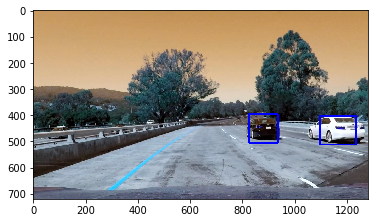

In [273]:
def video_pipline(
        img,svm_model_path, exprt_heatmap=False, usage_previous_frames=False,previou_heatmap=None
):
    '''
    Function to draw the rectangle into each video frame or the image.
    Process is:
    Step1: Compute the heat map of the image or the video frame.
    Step2: Remove false positive area from the heat map based on the threshould.
    Step3: Draw the rectangle on the area of the image, which was judged as "Vehicle image".
    For the video frame, we can add the heat map result of the previous few frames.
    In the case, the result of the previous heat map should be supplied for this function,
    This function to add the previous frame was added to reduce the false positive area,
     which randomly occurs in the image.
    :param img: The target image or the frame from the video
    :param svm_model_path: The path to the SVM model file to judge the image as the vehicle or not
    :param exprt_heatmap:
    If true, the function will return the heat map result in the addition to the image with the rectangle
    :param usage_previous_frames:
    If true, the heat map result from the previous frames will be used.
    :param previou_heatmap:
    the heat map results from the previous few frames
    :return:
    The image with the rectangles.
    If the exprt_heatmap is true, the original image and heat map result are returned as well.
    '''

    # Compute the heat map for the target image
    res = find_cars(img,0,1280, 350,600,1.5,svm_model_path)

    # Keep the original image
    original_res = np.copy(res)

    # Compute the false positive area based on the threshold.
    # Threshold for the video frames.
    if usage_previous_frames == True and type(previou_heatmap) != type(None):
        # Add the heat map results from the previous few frames.
        res = res + previou_heatmap
        mode_cal = res.flatten()
        mode_cal = np.delete(mode_cal, np.where(mode_cal == 0))
        # If the heat map is empty, the result is 0.
        if len(mode_cal) == 0:
            res = 0
            print("Mode was empty")
        # If the heat map
        else:
            thread = mode_cal.max() / 3
            print(thread)
            if thread < 65:
                # Threshold for very low value.
                # If the iamge doesn't include any vehicle image, this threshold will be applied.
                thread = 65
            else:
                pass
            res[res < thread] = 0
            print("thread is {}".format(thread))
        print('Threading_done')

    # Threshold for the single image.
    else:
        mode_cal = res.flatten()
        mode_cal = np.delete(mode_cal, np.where(mode_cal == 0))
        if len(mode_cal) == 0:
            res = 0
            print("Mode was empty")
        else:
            thread = mode_cal.max()/3
            print(thread)
            if thread < 10:
                thread=10
            else:
                pass
            res[res < thread] = 0
            print("thread is {}".format(thread))

        print('Threading_done')

    # Create label of each area which was surrounded by 0
    from scipy.ndimage.measurements import label
    labels = label(res)

    # Compute the coordinate of each labeled area
    bbox_output = []
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        box_height = np.max(nonzeroy)-np.min(nonzeroy)
        box_width = np.max(nonzerox)-np.min(nonzerox)
        # Draw the box on the image
        # Exclude box showng too bit aspect ratio

        # If the rectangle aspect ratio is less than 3 or the area is less than 150 pixels,
        #  the box is not applied to draw the rectangle.
        if box_height/box_width >= 3 or box_width/box_height >= 3 or box_height*box_width <= 150:
            pass
        else:
            # Draw the box into the image.
            print("OK_max:",res[np.min(nonzeroy):np.max(nonzeroy),np.min(nonzerox):np.max(nonzerox)].max())
            cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
            bbox_output.append(bbox)

    if exprt_heatmap == False:
        return img
    else:
        return img, original_res, res
    
test_image = cv2.imread("test_images/test1.jpg")
result_img, heat_map, after_rm_false_posi = video_pipline(test_image, "condition_4.pickle", exprt_heatmap=True)
plt.imshow(result_img)
plt.savefig("./report_images/5-images-result-2.png")



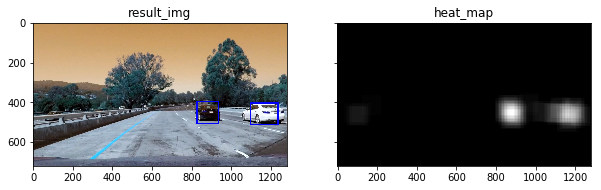

In [276]:
fig, (ax4, ax5) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

ax4.axis('on')
ax4.imshow(result_img,cmap=plt.cm.gray)
ax4.set_title('result_img',fontsize=12)
ax5.axis('on')
ax5.imshow(heat_map, cmap=plt.cm.gray)
ax5.set_title('heat_map',fontsize=12)
plt.savefig("./report_images/6-images-heatmap.png")
plt.show()

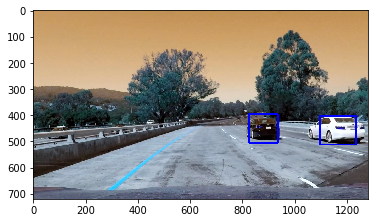

In [278]:
plt.imshow(result_img)
plt.savefig("./report_images/8-images-result.png")

In [241]:
def video_creation(
        original_video_name, output_video_name, svm_model_path, end_sec = 1, start_sec = 0, flg_whole_vide = False
):
    '''
    Function to draw the rectangle into the area, which is judged as "vehicle", of each frame from the original video.
    To apply the function to a part of the target video, start_sec and end_sec are set.
    :param original_video_name: Target video
    :param output_video_name: File name of the converted video file
    :param svm_model_path: The path to the SVM model file to judge the image as the vehicle or not
    :param end_sec: The end of the target frame. This is defined as [sec].
    :param start_sec: The start of the target frame. This is defined as [sec].
    :param flg_whole_vide:
    If ture, the function is applied on the whole frame of the target video,
    regardless of the contents of start_sec and end_sec.
    :return: Non
    '''

    # Read the video
    video = cv2.VideoCapture(original_video_name)

    # Extract the frames, defined by start_sec and end_sec.
    total_num_frame = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = video.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'avc1')
    w=int(video.get(cv2.CAP_PROP_FRAME_WIDTH )) 
    h=int(video.get(cv2.CAP_PROP_FRAME_HEIGHT ))
    out = cv2.VideoWriter(output_video_name, fourcc, fps, (w, h))
    start_frame = start_sec * fps
    end_frame = end_sec * fps
    if flg_whole_vide == True:
        start_frame = 1
        end_frame = total_num_frame
    else:
        pass

    # Convert the each frame.
    # Previous 3 frames are added into the result to reduce the false positive area, which randomly occurs in the image.

    previous_1_res = None
    previous_2_res = None
    previous_3_res = None
    add_data = None
    for num_frame in range(0,(int)(end_frame)):
        print(num_frame)
        if num_frame < start_frame:
            ret, frame = video.read() #pass until start flame
        else:
            print((int)(num_frame - start_frame), "/", (int)(end_frame - start_frame))
            ret, frame = video.read()
            if ret == True:

                # In the first 4 frames, the function to add the previous frame will be skipped.
                if num_frame <= start_frame + 5:
                    print('here')
                    result_frame, previous_res, after_rm_false_posi = video_pipline(
                        frame,svm_model_path, exprt_heatmap=True, usage_previous_frames=False
                    )
                    previous_3_res = previous_2_res
                    previous_2_res = previous_1_res
                    previous_1_res = previous_res
                else:
                    print(previous_1_res.max(), previous_2_res.max(), previous_3_res.max())
                    max1 = previous_1_res.max()
                    max2 = previous_2_res.max()
                    max3 = previous_3_res.max()
                    add_data = previous_1_res + previous_2_res + previous_3_res
                    result_frame, previous_res,  after_rm_false_posi = video_pipline(
                        frame,svm_model_path, exprt_heatmap=True, usage_previous_frames=True, previou_heatmap=add_data
                    )
                    previous_3_res = previous_2_res
                    previous_2_res = previous_1_res
                    previous_1_res = previous_res
                    print(previous_1_res.max(), previous_2_res.max(), previous_3_res.max())
                out.write(result_frame)

    video.release()
    out.release()
    cv2.destroyAllWindows()
    
video_creation('project_video.mp4','output_test_1.mp4','condition_4.pickle',42,40,True)




0
1
0 / 1259
here
4.333333333333333
thread is 10
Threading_done
OK_max: 13
2
1 / 1259
here
4.0
thread is 10
Threading_done
OK_max: 12
3
2 / 1259
here
5.333333333333333
thread is 10
Threading_done
OK_max: 11
OK_max: 16
4
3 / 1259
here
4.666666666666667
thread is 10
Threading_done
OK_max: 14
5
4 / 1259
here
4.333333333333333
thread is 10
Threading_done
OK_max: 13
6
5 / 1259
here
6.333333333333333
thread is 10
Threading_done
OK_max: 19
7
6 / 1259
19 13 14
20.0
thread is 65
Threading_done
14 19 13
8
7 / 1259
14 19 13
18.666666666666668
thread is 65
Threading_done
10 14 19
9
8 / 1259
10 14 19
18.0
thread is 65
Threading_done
11 10 14
10
9 / 1259
11 10 14
15.333333333333334
thread is 65
Threading_done
11 11 10
11
10 / 1259
11 11 10
15.333333333333334
thread is 65
Threading_done
15 11 11
12
11 / 1259
15 11 11
15.0
thread is 65
Threading_done
8 15 11
13
12 / 1259
8 15 11
15.333333333333334
thread is 65
Threading_done
12 8 15
14
13 / 1259
12 8 15
15.0
thread is 65
Threading_done
10 12 8
15
14 /

6.0
thread is 65
Threading_done
6 5 5
123
122 / 1259
6 5 5
8.0
thread is 65
Threading_done
8 6 5
124
123 / 1259
8 6 5
9.666666666666666
thread is 65
Threading_done
10 8 6
125
124 / 1259
10 8 6
11.0
thread is 65
Threading_done
9 10 8
126
125 / 1259
9 10 8
11.666666666666666
thread is 65
Threading_done
10 9 10
127
126 / 1259
10 9 10
11.333333333333334
thread is 65
Threading_done
12 10 9
128
127 / 1259
12 10 9
10.666666666666666
thread is 65
Threading_done
8 12 10
129
128 / 1259
8 12 10
9.333333333333334
thread is 65
Threading_done
8 8 12
130
129 / 1259
8 8 12
9.666666666666666
thread is 65
Threading_done
9 8 8
131
130 / 1259
9 8 8
8.666666666666666
thread is 65
Threading_done
6 9 8
132
131 / 1259
6 9 8
7.666666666666667
thread is 65
Threading_done
7 6 9
133
132 / 1259
7 6 9
7.0
thread is 65
Threading_done
8 7 6
134
133 / 1259
8 7 6
11.0
thread is 65
Threading_done
18 8 7
135
134 / 1259
18 8 7
17.0
thread is 65
Threading_done
21 18 8
136
135 / 1259
21 18 8
22.0
thread is 65
Threading_done

68.66666666666667
thread is 68.66666666666667
Threading_done
OK_max: 206
57 56 49
213
212 / 1259
57 56 49
71.33333333333333
thread is 71.33333333333333
Threading_done
OK_max: 214
55 57 56
214
213 / 1259
55 57 56
71.66666666666667
thread is 71.66666666666667
Threading_done
OK_max: 215
49 55 57
215
214 / 1259
49 55 57
70.33333333333333
thread is 70.33333333333333
Threading_done
OK_max: 211
50 49 55
216
215 / 1259
50 49 55
68.0
thread is 68.0
Threading_done
OK_max: 204
50 50 49
217
216 / 1259
50 50 49
66.33333333333333
thread is 66.33333333333333
Threading_done
OK_max: 199
50 50 50
218
217 / 1259
50 50 50
65.66666666666667
thread is 65.66666666666667
Threading_done
OK_max: 197
48 50 50
219
218 / 1259
48 50 50
64.66666666666667
thread is 65
Threading_done
OK_max: 194
47 48 50
220
219 / 1259
47 48 50
62.666666666666664
thread is 65
Threading_done
OK_max: 188
44 47 48
221
220 / 1259
44 47 48
61.333333333333336
thread is 65
Threading_done
OK_max: 184
46 44 47
222
221 / 1259
46 44 47
60.666666

53.333333333333336
thread is 65
Threading_done
OK_max: 160
34 43 46
305
304 / 1259
34 43 46
53.333333333333336
thread is 65
Threading_done
OK_max: 160
42 34 43
306
305 / 1259
42 34 43
50.666666666666664
thread is 65
Threading_done
OK_max: 152
OK_max: 66
39 42 34
307
306 / 1259
39 42 34
48.666666666666664
thread is 65
Threading_done
OK_max: 78
OK_max: 146
35 39 42
308
307 / 1259
35 39 42
52.666666666666664
thread is 65
Threading_done
OK_max: 158
OK_max: 83
46 35 39
309
308 / 1259
46 35 39
52.333333333333336
thread is 65
Threading_done
OK_max: 84
OK_max: 157
42 46 35
310
309 / 1259
42 46 35
53.0
thread is 65
Threading_done
OK_max: 159
OK_max: 70
43 42 46
311
310 / 1259
43 42 46
54.0
thread is 65
Threading_done
OK_max: 162
38 43 42
312
311 / 1259
38 43 42
54.0
thread is 65
Threading_done
OK_max: 162
39 38 43
313
312 / 1259
39 38 43
50.666666666666664
thread is 65
Threading_done
OK_max: 152
34 39 38
314
313 / 1259
34 39 38
47.333333333333336
thread is 65
Threading_done
OK_max: 142
37 34 39

48.666666666666664
thread is 65
Threading_done
OK_max: 146
39 43 35
399
398 / 1259
39 43 35
48.666666666666664
thread is 65
Threading_done
OK_max: 146
33 39 43
400
399 / 1259
33 39 43
47.666666666666664
thread is 65
Threading_done
OK_max: 143
29 33 39
401
400 / 1259
29 33 39
44.666666666666664
thread is 65
Threading_done
OK_max: 134
35 29 33
402
401 / 1259
35 29 33
43.666666666666664
thread is 65
Threading_done
OK_max: 131
34 35 29
403
402 / 1259
34 35 29
45.333333333333336
thread is 65
Threading_done
OK_max: 136
38 34 35
404
403 / 1259
38 34 35
48.333333333333336
thread is 65
Threading_done
OK_max: 145
39 38 34
405
404 / 1259
39 38 34
48.333333333333336
thread is 65
Threading_done
OK_max: 145
35 39 38
406
405 / 1259
35 39 38
46.0
thread is 65
Threading_done
OK_max: 138
27 35 39
407
406 / 1259
27 35 39
39.666666666666664
thread is 65
Threading_done
OK_max: 119
19 27 35
408
407 / 1259
19 27 35
35.666666666666664
thread is 65
Threading_done
OK_max: 107
26 19 27
409
408 / 1259
26 19 27
31

24.333333333333332
thread is 65
Threading_done
OK_max: 73
OK_max: 69
16 24 18
492
491 / 1259
16 24 18
21.333333333333332
thread is 65
Threading_done
15 16 24
493
492 / 1259
15 16 24
21.666666666666668
thread is 65
Threading_done
OK_max: 65
19 15 16
494
493 / 1259
19 15 16
23.0
thread is 65
Threading_done
OK_max: 69
19 19 15
495
494 / 1259
19 19 15
23.0
thread is 65
Threading_done
OK_max: 69
16 19 19
496
495 / 1259
16 19 19
23.333333333333332
thread is 65
Threading_done
OK_max: 70
16 16 19
497
496 / 1259
16 16 19
22.666666666666668
thread is 65
Threading_done
OK_max: 68
17 16 16
498
497 / 1259
17 16 16
21.0
thread is 65
Threading_done
14 17 16
499
498 / 1259
14 17 16
21.333333333333332
thread is 65
Threading_done
17 14 17
500
499 / 1259
17 14 17
21.666666666666668
thread is 65
Threading_done
18 17 14
501
500 / 1259
18 17 14
21.0
thread is 65
Threading_done
15 18 17
502
501 / 1259
15 18 17
24.333333333333332
thread is 65
Threading_done
OK_max: 73
24 15 18
503
502 / 1259
24 15 18
25.33333

32.0
thread is 65
Threading_done
OK_max: 74
OK_max: 96
25 23 23
582
581 / 1259
25 23 23
30.666666666666668
thread is 65
Threading_done
OK_max: 83
OK_max: 92
22 25 23
583
582 / 1259
22 25 23
32.333333333333336
thread is 65
Threading_done
OK_max: 97
OK_max: 95
31 22 25
584
583 / 1259
31 22 25
31.666666666666668
thread is 65
Threading_done
OK_max: 95
OK_max: 95
23 31 22
585
584 / 1259
23 31 22
33.0
thread is 65
Threading_done
OK_max: 99
OK_max: 96
25 23 31
586
585 / 1259
25 23 31
34.0
thread is 65
Threading_done
OK_max: 102
OK_max: 98
24 25 23
587
586 / 1259
24 25 23
33.333333333333336
thread is 65
Threading_done
OK_max: 100
OK_max: 88
30 24 25
588
587 / 1259
30 24 25
35.0
thread is 65
Threading_done
OK_max: 105
OK_max: 86
27 30 24
589
588 / 1259
27 30 24
33.0
thread is 65
Threading_done
OK_max: 99
OK_max: 82
24 27 30
590
589 / 1259
24 27 30
29.0
thread is 65
Threading_done
OK_max: 87
OK_max: 84
26 24 27
591
590 / 1259
26 24 27
31.666666666666668
thread is 65
Threading_done
OK_max: 82
OK_

20.0
thread is 65
Threading_done
14 15 15
678
677 / 1259
14 15 15
18.666666666666668
thread is 65
Threading_done
12 14 15
679
678 / 1259
12 14 15
17.666666666666668
thread is 65
Threading_done
12 12 14
680
679 / 1259
12 12 14
16.333333333333332
thread is 65
Threading_done
11 12 12
681
680 / 1259
11 12 12
16.666666666666668
thread is 65
Threading_done
15 11 12
682
681 / 1259
15 11 12
18.333333333333332
thread is 65
Threading_done
17 15 11
683
682 / 1259
17 15 11
21.333333333333332
thread is 65
Threading_done
21 17 15
684
683 / 1259
21 17 15
23.0
thread is 65
Threading_done
OK_max: 69
16 21 17
685
684 / 1259
16 21 17
24.0
thread is 65
Threading_done
OK_max: 72
18 16 21
686
685 / 1259
18 16 21
24.0
thread is 65
Threading_done
OK_max: 72
17 18 16
687
686 / 1259
17 18 16
23.0
thread is 65
Threading_done
OK_max: 69
18 17 18
688
687 / 1259
18 17 18
24.333333333333332
thread is 65
Threading_done
OK_max: 73
20 18 17
689
688 / 1259
20 18 17
23.333333333333332
thread is 65
Threading_done
OK_max: 

85.0
thread is 85.0
Threading_done
OK_max: 255
89 83 86
770
769 / 1259
89 83 86
84.66666666666667
thread is 84.66666666666667
Threading_done
OK_max: 254
OK_max: 93
98 89 83
771
770 / 1259
98 89 83
85.0
thread is 85.0
Threading_done
OK_max: 255
94 98 89
772
771 / 1259
94 98 89
85.0
thread is 85.0
Threading_done
OK_max: 255
OK_max: 110
90 94 98
773
772 / 1259
90 94 98
85.0
thread is 85.0
Threading_done
OK_max: 255
OK_max: 113
89 90 94
774
773 / 1259
89 90 94
85.0
thread is 85.0
Threading_done
OK_max: 255
OK_max: 109
96 89 90
775
774 / 1259
96 89 90
85.0
thread is 85.0
Threading_done
OK_max: 255
87 96 89
776
775 / 1259
87 96 89
85.0
thread is 85.0
Threading_done
OK_max: 255
92 87 96
777
776 / 1259
92 87 96
85.0
thread is 85.0
Threading_done
OK_max: 255
92 92 87
778
777 / 1259
92 92 87
85.0
thread is 85.0
Threading_done
OK_max: 255
82 92 92
779
778 / 1259
82 92 92
85.0
thread is 85.0
Threading_done
OK_max: 255
85 82 92
780
779 / 1259
85 82 92
85.0
thread is 85.0
Threading_done
OK_max: 255


85.0
thread is 85.0
Threading_done
OK_max: 255
79 75 86
861
860 / 1259
79 75 86
85.0
thread is 85.0
Threading_done
OK_max: 255
77 79 75
862
861 / 1259
77 79 75
84.66666666666667
thread is 84.66666666666667
Threading_done
OK_max: 254
71 77 79
863
862 / 1259
71 77 79
85.0
thread is 85.0
Threading_done
OK_max: 255
81 71 77
864
863 / 1259
81 71 77
84.33333333333333
thread is 84.33333333333333
Threading_done
OK_max: 253
73 81 71
865
864 / 1259
73 81 71
84.66666666666667
thread is 84.66666666666667
Threading_done
OK_max: 254
85 73 81
866
865 / 1259
85 73 81
84.0
thread is 84.0
Threading_done
OK_max: 252
81 85 73
867
866 / 1259
81 85 73
84.66666666666667
thread is 84.66666666666667
Threading_done
OK_max: 254
76 81 85
868
867 / 1259
76 81 85
85.0
thread is 85.0
Threading_done
OK_max: 255
81 76 81
869
868 / 1259
81 76 81
84.66666666666667
thread is 84.66666666666667
Threading_done
OK_max: 254
76 81 76
870
869 / 1259
76 81 76
85.0
thread is 85.0
Threading_done
OK_max: 255
70 76 81
871
870 / 1259

84.0
thread is 84.0
Threading_done
OK_max: 252
OK_max: 151
65 60 66
945
944 / 1259
65 60 66
81.33333333333333
thread is 81.33333333333333
Threading_done
OK_max: 244
OK_max: 146
54 65 60
946
945 / 1259
54 65 60
79.66666666666667
thread is 79.66666666666667
Threading_done
OK_max: 239
OK_max: 140
61 54 65
947
946 / 1259
61 54 65
78.0
thread is 78.0
Threading_done
OK_max: 234
OK_max: 134
54 61 54
948
947 / 1259
54 61 54
76.0
thread is 76.0
Threading_done
OK_max: 228
OK_max: 135
59 54 61
949
948 / 1259
59 54 61
76.33333333333333
thread is 76.33333333333333
Threading_done
OK_max: 229
OK_max: 140
55 59 54
950
949 / 1259
55 59 54
75.33333333333333
thread is 75.33333333333333
Threading_done
OK_max: 226
OK_max: 139
58 55 59
951
950 / 1259
58 55 59
77.66666666666667
thread is 77.66666666666667
Threading_done
OK_max: 233
OK_max: 145
61 58 55
952
951 / 1259
61 58 55
79.33333333333333
thread is 79.33333333333333
Threading_done
OK_max: 238
OK_max: 142
64 61 58
953
952 / 1259
64 61 58
83.3333333333333

59 57 71
79.66666666666667
thread is 79.66666666666667
Threading_done
OK_max: 239
OK_max: 221
61 59 57
1023
1022 / 1259
61 59 57
82.33333333333333
thread is 82.33333333333333
Threading_done
OK_max: 229
OK_max: 247
74 61 59
1024
1023 / 1259
74 61 59
81.0
thread is 81.0
Threading_done
OK_max: 227
OK_max: 243
55 74 61
1025
1024 / 1259
55 74 61
83.0
thread is 83.0
Threading_done
OK_max: 224
OK_max: 249
66 55 74
1026
1025 / 1259
66 55 74
85.0
thread is 85.0
Threading_done
OK_max: 224
OK_max: 255
73 66 55
1027
1026 / 1259
73 66 55
84.66666666666667
thread is 84.66666666666667
Threading_done
OK_max: 212
OK_max: 254
71 73 66
1028
1027 / 1259
71 73 66
85.0
thread is 85.0
Threading_done
OK_max: 206
OK_max: 255
59 71 73
1029
1028 / 1259
59 71 73
85.0
thread is 85.0
Threading_done
OK_max: 205
OK_max: 255
60 59 71
1030
1029 / 1259
60 59 71
84.66666666666667
thread is 84.66666666666667
Threading_done
OK_max: 195
OK_max: 254
67 60 59
1031
1030 / 1259
67 60 59
81.0
thread is 81.0
Threading_done
OK_max

57 56 53
75.33333333333333
thread is 75.33333333333333
Threading_done
OK_max: 174
OK_max: 226
60 57 56
1098
1097 / 1259
60 57 56
77.66666666666667
thread is 77.66666666666667
Threading_done
OK_max: 178
OK_max: 233
60 60 57
1099
1098 / 1259
60 60 57
80.33333333333333
thread is 80.33333333333333
Threading_done
OK_max: 182
OK_max: 241
66 60 60
1100
1099 / 1259
66 60 60
83.33333333333333
thread is 83.33333333333333
Threading_done
OK_max: 195
OK_max: 250
64 66 60
1101
1100 / 1259
64 66 60
84.33333333333333
thread is 84.33333333333333
Threading_done
OK_max: 184
OK_max: 253
71 64 66
1102
1101 / 1259
71 64 66
85.0
thread is 85.0
Threading_done
OK_max: 189
OK_max: 255
78 71 64
1103
1102 / 1259
78 71 64
85.0
thread is 85.0
Threading_done
OK_max: 183
OK_max: 255
73 78 71
1104
1103 / 1259
73 78 71
85.0
thread is 85.0
Threading_done
OK_max: 181
OK_max: 255
67 73 78
1105
1104 / 1259
67 73 78
84.33333333333333
thread is 84.33333333333333
Threading_done
OK_max: 180
OK_max: 253
58 67 73
1106
1105 / 125

1175
1174 / 1259
20 25 29
32.0
thread is 65
Threading_done
OK_max: 96
23 20 25
1176
1175 / 1259
23 20 25
31.666666666666668
thread is 65
Threading_done
OK_max: 95
29 23 20
1177
1176 / 1259
29 23 20
33.666666666666664
thread is 65
Threading_done
OK_max: 101
31 29 23
1178
1177 / 1259
31 29 23
35.666666666666664
thread is 65
Threading_done
OK_max: 107
26 31 29
1179
1178 / 1259
26 31 29
36.333333333333336
thread is 65
Threading_done
OK_max: 109
23 26 31
1180
1179 / 1259
23 26 31
36.0
thread is 65
Threading_done
OK_max: 108
28 23 26
1181
1180 / 1259
28 23 26
34.666666666666664
thread is 65
Threading_done
OK_max: 104
27 28 23
1182
1181 / 1259
27 28 23
36.333333333333336
thread is 65
Threading_done
OK_max: 109
31 27 28
1183
1182 / 1259
31 27 28
37.333333333333336
thread is 65
Threading_done
OK_max: 112
26 31 27
1184
1183 / 1259
26 31 27
36.0
thread is 65
Threading_done
OK_max: 108
25 26 31
1185
1184 / 1259
25 26 31
36.0
thread is 65
Threading_done
OK_max: 108
28 25 26
1186
1185 / 1259
28 25 2

In [242]:
white_output = "output_test_1.mp4"
HTML("""
<video width="640" height="300" controls>
  <source src="{0}">
</video>
""".format(white_output))